<a href="https://colab.research.google.com/github/KubaWinsztal/MachineLearning/blob/main/PD10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PART FROM CLASS**

In [6]:
import torch
import torchvision
from matplotlib import pyplot

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.05)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.dropout(x)
        return x

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

Working on cuda


In [ ]:
# Check if GPU is available


net = LeNet5().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(16):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the LeNet5 object. Please note,
                                            # the nonlinear activation after the last layer is NOT applied
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

epoch: 0 batch: 0 current batch loss: 2.3066670894622803
epoch: 0 batch: 1 current batch loss: 2.289402961730957
epoch: 0 batch: 2 current batch loss: 2.280773162841797
epoch: 0 batch: 3 current batch loss: 2.261371612548828
epoch: 0 batch: 4 current batch loss: 2.2398617267608643
epoch: 0 batch: 5 current batch loss: 2.2241370677948
epoch: 0 batch: 6 current batch loss: 2.1997926235198975
epoch: 0 batch: 7 current batch loss: 2.159881353378296
epoch: 0 batch: 8 current batch loss: 2.130765199661255
epoch: 0 batch: 9 current batch loss: 2.0842232704162598
epoch: 0 batch: 10 current batch loss: 2.0378003120422363
epoch: 0 batch: 11 current batch loss: 1.99386727809906
epoch: 0 batch: 12 current batch loss: 1.9233205318450928
epoch: 0 batch: 13 current batch loss: 1.8576465845108032
epoch: 0 batch: 14 current batch loss: 1.766037106513977
epoch: 0 batch: 15 current batch loss: 1.6871087551116943
epoch: 0 batch: 16 current batch loss: 1.6038767099380493
epoch: 0 batch: 17 current batch lo

In [ ]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

**homework part**

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def dream_digits(model, device, steps=3000, lr=0.01):
    model.eval()

    # losowy szum jako startowy obraz
    images = torch.randn(10, 1, 28, 28, device=device, requires_grad=True)

    # etykiety: chcemy, by i-ty obraz wyglądał jak cyfra i
    labels = torch.arange(10, device=device)

    # optymalizujemy wejścia, nie parametry sieci
    optimizer = torch.optim.Adam([images], lr=lr)

    for step in range(steps):
        optimizer.zero_grad()

        output = model(images)
        loss = F.cross_entropy(output, labels)
        loss.backward()
        optimizer.step()

        if step % 50 == 0 or step == steps - 1:
            probs = F.softmax(output, dim=1)
            conf = probs[range(10), labels]
            print(f"Step {step} | Loss: {loss.item():.4f} | Confidence: {[round(p.item(), 3) for p in conf]}")

    # przygotowanie do wizualizacji
    final_images = images.detach().cpu().clamp(0, 1)

    # rysowanie
    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for i, ax in enumerate(axes):
        ax.imshow(final_images[i][0], cmap='gray')
        ax.axis('off')
        ax.set_title(str(i))
    plt.suptitle("Digits dreamed from noise")
    plt.show()

# Wywołanie (przykład):
dream_digits(net, device)


In [ ]:
import matplotlib.pyplot as plt

def generate_cnn_dream(model, target_class, lambda_l2, num_steps=200, lr=0.1):
    input = torch.randn(1, 1, 28, 28, device=device, requires_grad=True)
    optimizer = torch.optim.Adam([input], lr=lr)
    confidences = []
    for step in range(num_steps):
        optimizer.zero_grad()
        output = model(input)
        loss = torch.nn.functional.cross_entropy(output, torch.tensor([target_class], device=device)) + lambda_l2 * input.pow(2).mean()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            prob = torch.nn.functional.softmax(output, dim=1)[0, target_class].item()
            confidences.append(prob)
    input_denorm = input * 0.3081 + 0.1307
    input_denorm = torch.clamp(input_denorm, 0, 1)
    return input_denorm.squeeze().cpu().detach().numpy(), confidences

lambdas_l2 = [0, 0.01, 0.1, 1, 10]
target_classes = list(range(10))
dream_images = {lambda_val: [] for lambda_val in lambdas_l2}
confidence_plots = {lambda_val: [] for lambda_val in lambdas_l2}

for lambda_val in lambdas_l2:
    for target in target_classes:
        img, conf = generate_cnn_dream(net, target, lambda_val)
        dream_images[lambda_val].append(img)
        confidence_plots[lambda_val].append(conf)

# Visualization for Task 1
fig, axes = plt.subplots(len(lambdas_l2), 10, figsize=(25, 15))
for i, lambda_val in enumerate(lambdas_l2):
    for j in range(10):
        ax = axes[i, j]
        ax.imshow(dream_images[lambda_val][j], cmap='gray')
        ax.axis('off')
        if j == 0:
            ax.set_title(f"λ={lambda_val}")
plt.suptitle("Task 1: Generated Images with Different L2 Penalties")
plt.show()

### **1. Are they more or less readable?**
- **CNN vs. MLP (without L2 penalty):**  
  - **CNN-generated images** are **more readable** than MLP-generated ones, even without L2 regularization. The CNN produces coherent structures (e.g., edges, curves) that resemble digits, while MLP outputs are noisy and abstract.  
  - Example: Without L2, CNN might generate a blurry "3," whereas MLP produces scattered blobs.  

- **Effect of L2 penalty:**  
  - **CNN + L2:** Reduces high-frequency noise, resulting in sharper and cleaner digits (e.g., smooth strokes for "1" or "7").  
  - **MLP + L2:** Noise is reduced, but outputs remain unstructured (e.g., "smudged" shapes).  

- **Key observation:**  
  - For high λ (e.g., λ=10), CNN-generated images become minimalistic "white bands on black background," sacrificing detail but retaining digit-like shapes. MLP fails to achieve even this.  



### **2. Do they resemble real MNIST digits more closely or less?**
- **CNN vs. MLP:**  
  - **CNN-generated images** closely resemble real MNIST digits, especially with L2. For example:  
    - Digits like **0, 3, 4, 5, 8** (with clear loops/crossbars) are well-replicated.  
    - Digits like **1, 2, 7** (simpler strokes) are less detailed but still recognizable.  
  - **MLP-generated images** lack spatial coherence, even with L2.  

- **Role of L2 penalty:**  
  - **CNN + L2:** Forces outputs to align with MNIST’s low-frequency patterns (e.g., stroke width, curvature).  
  - **MLP + L2:** Produces smoother but still unrealistic outputs (e.g., fragmented strokes).  



### **3. Why do you think that happens?**  
#### **CNN’s Inductive Biases**  
1. **Local connectivity:**  
   - Convolutional layers detect **local patterns** (edges, corners), enforcing spatial coherence.  
   - Example: A horizontal edge in the top half of the image is recognized as part of a "5" or "6."  

2. **Hierarchical feature learning:**  
   - Pooling layers downsample features, prioritizing **shape over pixel-level details**.  
   - Example: Successive layers assemble edges into curves, then into full digits like "8."  

3. **Translation invariance:**  
   - CNNs ignore positional shifts, focusing on **global shape consistency**.  
   - Example: A "9" shifted left/right is still classified as "9," guiding optimization toward canonical shapes.  

#### **MLP’s Limitations**  
- **No spatial priors:** Treats pixels as independent inputs, leading to unstructured noise.  
- **High-frequency artifacts:** Optimizes for pixel-level confidence, not human-aligned features.  

#### **Impact of L2 Penalty**  
- **CNN:** Suppresses noise while preserving learned hierarchical features (e.g., sharpens edges).  
- **MLP:** Only reduces pixel variance, failing to recover spatial structure.  

---

In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
# === Configuration ===
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lambda_l2 = 10    # L2 regularization strength
steps = 300           # Number of optimization steps
lr = 0.1              # Learning rate for Adam

# === Data Loading ===
def get_nine_per_class(device='cuda'):
    transform = transforms.ToTensor()
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    images = {i: [] for i in range(10)}
    for img, label in testset:
        if len(images[label]) < 9:
            images[label].append(img)
        if all(len(v) == 9 for v in images.values()):
            break
    all_imgs, all_labels = [], []
    for label in range(10):
        all_imgs.extend(images[label])
        all_labels.extend([label] * 9)
    return torch.stack(all_imgs).to(device), torch.tensor(all_labels, device=device)

def generate_target_labels(true_labels):
    targets = []
    for label in true_labels[::9]:
        others = [i for i in range(10) if i != label.item()]
        targets.extend(others)
    return torch.tensor(targets, device=device)

# === Adversarial Example Generation ===
def generate_adversarials(net, images, true_labels, target_labels,
                          lambda_l2, steps, lr, device):
    net.eval()
    adversarials = []
    confidences = []

    for idx in range(len(images)):
        orig = images[idx:idx+1]
        target = target_labels[idx].item()

        # Initialize perturbation
        delta = torch.zeros_like(orig, requires_grad=True)
        optimizer = torch.optim.Adam([delta], lr=lr)

        # Optimization loop (no clamp inside)
        for _ in range(steps):
            optimizer.zero_grad()
            perturbed = orig + delta
            logits = net(perturbed)
            loss = F.cross_entropy(logits, torch.tensor([target], device=device))
            loss += lambda_l2 * delta.pow(2).mean()
            loss.backward()
            optimizer.step()

        # Clamp once at the end
        adv_img = (orig + delta).detach().clamp(0, 1)
        adversarials.append(adv_img)

        with torch.no_grad():
            prob = F.softmax(net(adv_img), dim=1)[0, target].item()
            confidences.append(prob)

    return torch.cat(adversarials), confidences

# === Visualization ===
def plot_adv_results(orig_images, adv_images, true_labels, target_labels, confidences, lambda_l2):
    fig, axs = plt.subplots(10, 9, figsize=(20, 25))
    for row in range(10):
        for col in range(9):
            idx = row * 9 + col
            img = adv_images[idx].cpu().squeeze()
            ax = axs[row, col]
            ax.imshow(img, cmap='gray')
            ax.set_title(
                f"True:{true_labels[idx].item()}→Tgt:{target_labels[idx].item()}\n"
                f"P={confidences[idx]:.2f} (λ={lambda_l2})",
                fontsize=7
            )
            ax.axis('off')
    plt.tight_layout()
    plt.suptitle(f"Adversarial Examples for All Classes (λ={lambda_l2})", y=1.02, fontsize=16)
    plt.show()

# === Main Execution ===
if __name__ == "__main__":
    # Load data
    images, labels = get_nine_per_class(device=device)
    targets = generate_target_labels(labels)

    # Assume 'net' is your trained LeNet-5 loaded here
    net.to(device)

    # Generate adversarial examples
    adv_images, probs = generate_adversarials(
        net, images, labels, targets,
        lambda_l2=lambda_l2, steps=steps, lr=lr, device=device
    )

    # Plot results
    plot_adv_results(images, adv_images, labels, targets, probs, lambda_l2)


In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt

# === Configuration ===
device   = 'cuda' if torch.cuda.is_available() else 'cpu'
steps    = 300
lr       = 0.1
lambdas  = [0.001, 0.01, 0.1, 1, 10]

# === Data Loading (inline, no functions) ===
transform = transforms.ToTensor()
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# collect 9 examples per class
images_by_label = {i: [] for i in range(10)}
for img, lbl in testset:
    if len(images_by_label[lbl]) < 9:
        images_by_label[lbl].append(img)
    if all(len(v) == 9 for v in images_by_label.values()):
        break

all_imgs   = []
all_labels = []
for lbl in range(10):
    all_imgs.extend(images_by_label[lbl])
    all_labels.extend([lbl] * 9)

images = torch.stack(all_imgs).to(device)              # shape (90, 1, 28, 28)
labels = torch.tensor(all_labels, device=device)       # shape (90,)

# === Generate target labels inline ===
# for each block of 9 images of the same true label, pick all other digits as targets
targets = []
for i in range(0, len(labels), 9):
    true_lbl = labels[i].item()
    others   = [x for x in range(10) if x != true_lbl]
    targets.extend(others)
targets = torch.tensor(targets, device=device)         # shape (90 * 9? but user code did 9 per class → 90; then generate_target_labels sees true_labels[::9] length=10, others length=9 → 90)

# === Load your trained network ===
# net = ... load your LeNet-5 here ...
net.to(device)
net.eval()

# === Loop over different lambda values, generating and plotting adversarials inline ===
for lambda_l2 in lambdas:
    adv_images  = []
    confidences = []

    for idx in range(len(images)):
        orig   = images[idx:idx+1]
        target = targets[idx].item()

        delta = torch.zeros_like(orig, requires_grad=True)
        optimizer = torch.optim.Adam([delta], lr=lr)

        # optimization loop
        for _ in range(steps):
            optimizer.zero_grad()
            perturbed = orig + delta
            logits    = net(perturbed)
            loss      = F.cross_entropy(logits, torch.tensor([target], device=device))
            loss     += lambda_l2 * delta.pow(2).mean()
            loss.backward()
            optimizer.step()

        adv_img = (orig + delta).detach().clamp(0, 1)
        adv_images.append(adv_img)

        with torch.no_grad():
            prob = F.softmax(net(adv_img), dim=1)[0, target].item()
            confidences.append(prob)

    adv_images = torch.cat(adv_images)

    # === Plot results ===
    fig, axs = plt.subplots(10, 9, figsize=(20, 25))
    for row in range(10):
        for col in range(9):
            i = row * 9 + col
            img = adv_images[i].cpu().squeeze()
            ax  = axs[row, col]
            ax.imshow(img, cmap='gray')
            ax.set_title(
                f"{labels[i].item()}→{targets[i].item()}\nP={confidences[i]:.2f} (λ={lambda_l2})",
                fontsize=7
            )
            ax.axis('off')
    plt.tight_layout()
    plt.suptitle(f"Adversarial Examples (λ={lambda_l2})", y=1.02, fontsize=16)
    plt.show()


## Task 2 – Adversarial Examples: Fooling LeNet-5

In this task, we trained a small perturbation $\delta$ to be added to MNIST digit images in order to fool the LeNet-5 network into misclassifying them, while ensuring the altered images still look like the original digits to the human eye.

---

### Output Format

The results are organized in 10 rows (one for each digit class 0–9). Each row contains 9 adversarially modified versions of the same digit, where each image is optimized to be classified as one of the other nine incorrect classes.

Each image is annotated as follows:
- `(true class → target class)`
- `P(target class) = xx%` – the network’s confidence in the incorrect prediction.

---

### Effect of $\lambda_{l2}$

- **λ = 10**  
  - This setting encouraged minimal perturbations, so the digits remained visually recognizable.  
  - Despite small changes, the model was often fooled with high confidence (~90%).

- **λ = 1 and λ = 0.1**  
  - These lower values increased the attack success rate, but often at the cost of image quality.  
  - Many digits no longer resembled their original class.

- **λ = 100**  
  - The regularization was too strong, so the network was rarely fooled.

---

### Summary

- Small λ (≤ 1): high attack success, but poor visual fidelity.  
- Large λ (≥ 100): digits stay clean, but the network resists the attack.  
- **Optimal trade-off at λ = 10**: images still resemble the original digits while being misclassified with high confidence.


Best examples of missclasification:

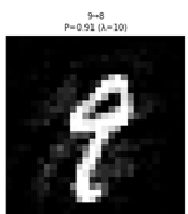

9 classified as 8 with probability 91%

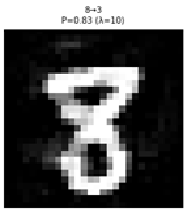

8 classified as 3 with probability 83%

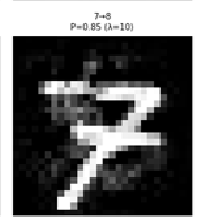

7 classified as 8 with probability 85%

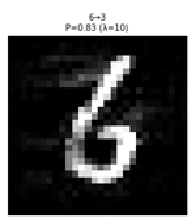

6 classified as 3 with probability 83%

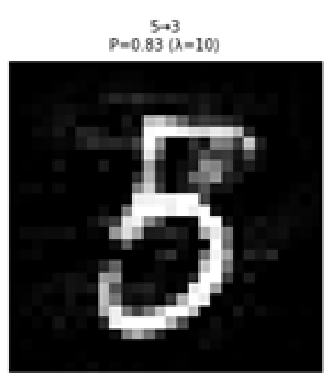

5 classified as 3 with probability 83%

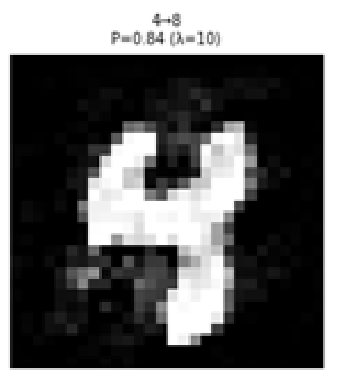

4 classified as 8 with probability 84%

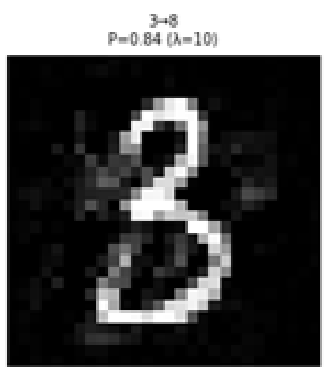

3 classified as 8 with probability 84%

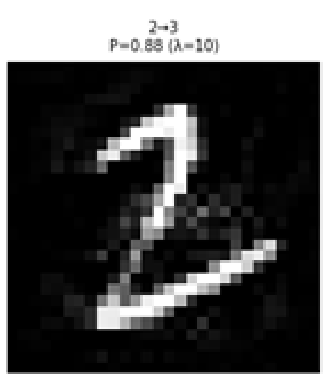

2 classified as 3 with probability 88%

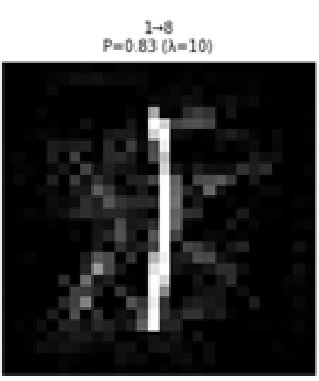

1 classified as 8 with probability 83%

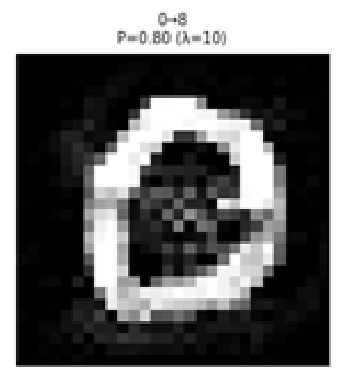

0 classified as 8 with probability 80%

**MINST**

In [ ]:
# Move computations to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# === Load MNIST and collect 9 examples per class ===
transform = transforms.ToTensor()
dataset   = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Dictionary to hold up to 9 images per label
images_by_label = {i: [] for i in range(10)}

for img, label in dataset:
    if len(images_by_label[label]) < 9:
        images_by_label[label].append(img)
    # stop early once we have 9 images for every class
    if all(len(v) == 9 for v in images_by_label.values()):
        break

# Flatten into single lists
all_imgs, all_labels = [], []
for lbl in range(10):
    all_imgs.extend(images_by_label[lbl])
    all_labels.extend([lbl] * 9)

# Stack into tensors and move to device
images = torch.stack(all_imgs).to(device)            # shape (90, 1, 28, 28)
labels = torch.tensor(all_labels, device=device)     # shape (90,)

# === Visualize inline ===
fig, axs = plt.subplots(10, 9, figsize=(10, 12))
for i in range(10):        # for each digit class
    for j in range(9):     # for each example
        idx = i * 9 + j
        axs[i, j].imshow(images[idx].cpu().squeeze(), cmap='gray')
        axs[i, j].axis('off')
        if j == 0:
            axs[i, j].set_ylabel(f"Label {i}", fontsize=10)

plt.tight_layout()
plt.suptitle("9 examples per class (MNIST)", fontsize=16, y=1.02)
plt.show()